# Predictor Importance by Class for Random Forrest Classifiers
Use the Gini index of each split in a tree of a random forrest to calculate the importance of each predictor to an accurate classification of each class in a dataset.

In [1]:
%%latex
`Algorithm pseudocode:  
importance_matrix = [class, feature, trees] 
for tree in forest:
    get the leaves of the tree
    for l in leaves:
        curr_node = l
        while hasParent(currNode) and isNotVisited[class, currNode]:
            isNotVisited[class, currNode] = False
            currNode = parent(currNode)
            importance_matrix[class, feature, tree] = currNode's change in MDG
averageImportanceOverAllTrees --> matrix of [class, feature]`

<IPython.core.display.Latex object>

In [67]:
# import packages
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
import pydot
from tqdm import tqdm
import seaborn as sns

In [43]:
# import the dataset
wines = pd.read_csv('../0_data/wines.csv')
data_names = ['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 
                 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 
                 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280-OD315 of diluted wines', 'Proline']
wines.columns = data_names
wines.head(5)

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280-OD315 of diluted wines,Proline
0,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


In [44]:
# separate the dataset into features (X) and categories (Y)
Y = wines['Class']
feature_names = data_names[1:]
X = np.array(wines[feature_names])
X = np.array(X)

In [45]:
# separate the data into training and testing splits
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.25, random_state = 42)

In [51]:
# train the random forrest classifier
# training with 1000 trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(train_X, train_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [52]:
# make predictions and calculate the error
predictions = rf.predict(test_X)
errors = abs(predictions - test_Y)
print('Mean Absolute Error: {}'.format(round(np.mean(errors), 2))) # Print out the mean absolute error (mae)

Mean Absolute Error: 0.04


In [53]:
# check the accuracy of the classifier with mean absolute percentage error (MAPE)
mape = 100 * (errors / test_Y)
accuracy = 100 - np.mean(mape)
print('Accuracy: {}%'.format(round(accuracy, 2)))

Accuracy: 97.78%


The accuracy is above 90%, so the judgement call is to proceed with implementing the PIBC algorithm on this classifier. We can then isolate a single tree and parse the tree structure similar to how the authors of Sci-Kit Learn do [here](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html). Additional resource: [https://stackoverflow.com/questions/32506951/how-to-explore-a-decision-tree-built-using-scikit-learn](https://stackoverflow.com/questions/32506951/how-to-explore-a-decision-tree-built-using-scikit-learn)

In [54]:
estimator = rf.estimators_[1]

# parse the tree structure into arrays
n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold

In [55]:
node_stuff = estimator.tree_.__getstate__()['nodes']
print(node_stuff)

[( 1, 10,  6,  1.30500001e+00, 0.62454086, 85, 132.)
 ( 2,  3,  8,  4.84999999e-01, 0.27777778, 23,  36.)
 (-1, -1, -2, -2.00000000e+00, 0.        ,  2,   4.)
 ( 4,  9,  4,  1.28000000e+02, 0.1171875 , 21,  32.)
 ( 5,  8,  2,  2.23500001e+00, 0.06243496, 20,  31.)
 ( 6,  7,  8,  1.43000001e+00, 0.44444444,  2,   3.)
 (-1, -1, -2, -2.00000000e+00, 0.        ,  1,   2.)
 (-1, -1, -2, -2.00000000e+00, 0.        ,  1,   1.)
 (-1, -1, -2, -2.00000000e+00, 0.        , 18,  28.)
 (-1, -1, -2, -2.00000000e+00, 0.        ,  1,   1.)
 (11, 12,  9,  3.46000004e+00, 0.47634549, 62,  96.)
 (-1, -1, -2, -2.00000000e+00, 0.        , 31,  51.)
 (13, 16,  3,  1.78999996e+01, 0.3545679 , 31,  45.)
 (14, 15, 11,  2.58500004e+00, 0.18549346, 19,  29.)
 (-1, -1, -2, -2.00000000e+00, 0.        ,  1,   3.)
 (-1, -1, -2, -2.00000000e+00, 0.        , 18,  26.)
 (17, 22, 12,  7.42000000e+02, 0.5390625 , 12,  16.)
 (18, 19,  0,  1.29000001e+01, 0.24489796,  6,   7.)
 (-1, -1, -2, -2.00000000e+00, 0.        ,  3,

## Implementing the algorithm in raw code

In [56]:
imp_mat = np.zeros((estimator.n_classes_, estimator.n_features_))
print(estimator.n_classes_)
print(estimator.n_features_)

3
13


In [79]:
leaves = []
for i in range(len(node_stuff)):
    if node_stuff[i][0] == -1 and node_stuff[i][1] == -1:
        leaves.append(i)
print(leaves)
estimator.tree_.__getstate__()['values'][leaves]
print(estimator.tree_.n_features)

[2, 6, 7, 8, 9, 11, 14, 15, 18, 20, 21, 22]
13


In [74]:
def findImp(rf_clf, res_panel_features):
    importance_matrix = []
    k = 0
    for dec_tree in rf_clf.estimators_:
        k += 1
        #print(k)
        #print(dec_tree.tree_.__getstate__()['max_depth'])
        #dec_tree = rf_clf.estimators_[0]
        classes = rf_clf.classes_#np.unique(y)
        #print('CHECK:', dec_tree.tree_.n_classes[0]==len(classes))
        feature = dec_tree.tree_.feature

        n_nodes = dec_tree.tree_.__getstate__()['node_count']
        nodes = dec_tree.tree_.__getstate__()['nodes']
        parent_node_ind = -np.ones(shape=n_nodes, dtype='<i8')
        for par_ind,node in enumerate(nodes):
            parent_node_ind[node[0]] = par_ind
            parent_node_ind[node[1]] = par_ind

        is_leaves = np.array([node[0]==node[1] for node in nodes])# np.zeros(shape=n_nodes, dtype=bool)
        #leaves = nodes[is_leaves]
        leaves_index = np.nonzero(is_leaves)[0]

        leaves_parent = parent_node_ind[is_leaves]

        values_sorted = dec_tree.tree_.__getstate__()['values']
        node_pred = np.argmax(values_sorted[:,0,:], axis=1)
        leaves_class_index = node_pred[is_leaves]
        #leaves_class = classes[leaves_class_index]


        ###TO BE SANITY-CHECKED
        node_unvisited = np.ones((len(classes), n_nodes), dtype=bool)
        tree_importances = np.zeros((len(classes),len(res_panel_features)))
        for leaf_i,leaf_c_i in zip(leaves_index,leaves_class_index):
            parent_i = parent_node_ind[leaf_i]
            current_i = leaf_i

            while parent_i != -1 and node_unvisited[leaf_c_i,current_i]:
                current_node = nodes[current_i]
                left_node = nodes[current_node['left_child']]
                right_node = nodes[current_node['right_child']]
                current_feature = current_node['feature']
                tree_importances[leaf_c_i,current_feature] += (
                        current_node['weighted_n_node_samples'] * current_node['impurity'] -
                        left_node['weighted_n_node_samples'] * left_node['impurity'] -
                        right_node['weighted_n_node_samples'] * right_node['impurity']
                        )
                node_unvisited[leaf_c_i,current_i] = False
                current_i = parent_i
                parent_i = parent_node_ind[current_i]
        importance_matrix.append(tree_importances)
    importance_matrix = np.mean(importance_matrix, axis = 0)
    return(importance_matrix)

In [75]:
imp_mat = findImp(rf, feature_names)
imp_mat

array([[4.1559087 , 1.16267427, 0.62178312, 2.02382686, 1.46067465,
        2.43861931, 4.17477436, 0.76171221, 0.70014437, 4.22024486,
        2.10165496, 3.77326578, 5.40415566],
       [6.48534737, 2.06440886, 0.90686039, 2.03455351, 1.82306697,
        3.37085998, 6.66954286, 1.03871744, 1.26228357, 7.80119449,
        4.0308093 , 6.22006514, 8.40488538],
       [3.3279314 , 1.51819422, 0.59074105, 1.22262825, 0.73222719,
        2.91436828, 5.7242968 , 0.80567284, 1.10071974, 5.40455974,
        3.91082257, 6.00445683, 5.46408949]])

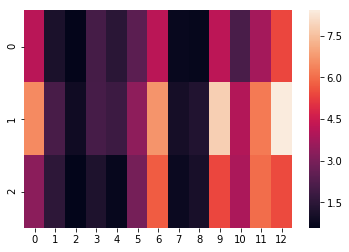

In [76]:
sns.heatmap(imp_mat)